# L-RVGA for rotation MNIST

The Limited-memory Recursive Variational Gaussian Approximation equations are given by

$$
\begin{aligned}
    q^*_t(\theta) &= \arg\min_{\mu^*, P^*}
        \text{KL}\left(  \mathcal{N}(\theta \vert \mu^*, P^*)  || \mathcal{N}(\theta \vert \mu_{t-1}, P_{t-1}^{-1}) p(y_t \vert\theta) \right)\\
    q_t(\theta) &= \arg\min_{\mu, W, \Psi}
         \text{KL}\left( \mathcal{N}(\theta \vert \left(WW^T + \Psi\right)^{-1} || \mathcal{N}(\theta \vert \mu^*, P^*)   \right)
\end{aligned}
$$

In [1]:
import jax
import chex
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamax.utils import datasets
from jaxtyping import Array, Float

In [2]:
%config InlineBackend.figure_format = "retina"

## Load Rotation MNIST

In [3]:
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X = jnp.array(X_train)[:num_train]
y = jnp.array(y_train)[:num_train]

# # Gaussianise
# X = (X - X.mean()) / X.std()

# ix_sort = jnp.argsort(y)
# X = X[ix_sort]
# y = y[ix_sort]

## L-RVGA

We consider a linear problem. Let $y_t = \theta^T x_t + \epsilon_t$, $\epsilon_t \sim \mathcal{N}(0, 1)$. Considering the approximated R-VGA, the update for $\mu_t\in\mathbb{R}^{d}$, $W_t\in\mathbb{R}^{d\times p}$, and $\Psi_t\in\mathbb{R}^{d\times d}$ becomes

$$
\begin{aligned}
\mu_t &= \mu_{t-1} + \left(W_t W_t^\intercal + \Psi_t\right)^{-1}x_t\left(y_t - \mu_{t-1}^\intercal x_t\right)\\
W_t W_t^\intercal + \Psi_t &\underset{\text{FA}}{\approx} \alpha_t\left( W_{t-1}W_{t-1}^\intercal + \Psi_{t-1} \right) + \beta x_tx_t^\intercal
\end{aligned}
$$

The FA update for the posterior covariance is obtained by iterating `nb_inner_loop` number of times the following set of equations

$$
\begin{aligned}
M &= {\bf I}_p + W^\intercal \Psi^{-1} W\\
V &= \beta_t x_tx_t^\intercal\Psi^{-1} W + \alpha_t\left[ W_{t-1}W_{t-1}^\intercal \Psi^{-1} W + \Psi_{t-1}\Psi^{-1} W \right]\\
W^{(n)} &= V\left({\bf I}_p + M^{-1} W^\intercal\Psi^{-1}V\right)^{-1}\\
\Psi^{(n)} &= \beta_t \text{diag}\left(x_tx_t^\intercal\right) + \alpha_t \text{diag}\left(W_{t-1}W_{t-1}^\intercal\right) + \alpha_t\Psi_{t-1} - \text{diag}\left(W^{(n)}M^{-1}V^\intercal\right)\\
W &= W^{(n)}, \Psi = \Psi^{(n)}
\end{aligned}
$$

In [4]:
@chex.dataclass
class LRVGAState:
    mu: Float[Array, "dim_params"]
    W: Float[Array, "dim_params dim_subspace"]
    Psi: Float[Array, "dim_params"]


def fa_approx_step(
    state: LRVGAState,
    state_prev: LRVGAState,
    alpha: float,
    beta: float
) -> LRVGAState:
    """
    Factor Analysis (FA) approximation to the low-rank (W)
    and diagonal (Psi) matrices.
    """
    # Load data
    W_prev, Psi_prev = state_prev.W, state_prev.Psi
    W, Psi = state.W, state.Psi
    
    # Initialise basic transformations
    dim_obs, dim_latent = W.shape
    I = jnp.eye(dim_latent)
    Psi_inv = 1 / Psi
    
    # Construct helper matrices
    M = I + jnp.einsum("ij,i,ik->jk", W, Psi_inv, W)
    M_inv = jnp.linalg.inv(M)
    V_beta = jnp.einsum("i,j,j,jk->ik", x, x, Psi_inv, W)
    V_alpha = (
        jnp.einsum("ij,kj,k,kl->il", W_prev, W_prev, Psi_inv, W) +
        jnp.einsum("i,i,ij->ij", Psi_prev, Psi_inv, W)
    )
    V = beta * V_beta + alpha * V_alpha
    
    # Value_update
    # TODO: double checkm matrix inversion
    W_solve = I + jnp.einsum("ij,kj,k,kl->il", M_inv, W, Psi_inv, V)
    W = jnp.linalg.solve(W_solve, V.T).T
    Psi = (
        beta * jnp.einsum("i,i", x, x) +
        alpha * jnp.einsum("ij,ij->i", W_prev, W_prev) + 
        alpha * Psi_prev -
        jnp.einsum("ij,jk,ik->i", W, M_inv, V)
    )
    
    new_state = state.replace(
        mu=state.mu,
        W=W,
        Psi=Psi
    )
    return new_state

### Initialisiation

We consider the initialisiation rule of §5.1.2:
1. $\Psi_0 = \psi_0 {\bf I}_d$, where $\psi_0 > 0$,
2. $W_0 \in \mathbb{R}^{d\times p}$,  where the columns are random vectors independently drawn from an istropic Gaussian distribution in $\mathbb{R}^d$ and which have been normalised so that $\forall k. ||u_k|| = w_0$.
We let

$$
\begin{aligned}
    \psi_0 &= (1 - \epsilon) \frac{1}{\sigma^2_0},\\
    w_0 &= \sqrt{\frac{\epsilon d}{p\sigma^2_0}}
\end{aligned}
$$

with $0 < \epsilon \ll 1$ a small parameter.

In [5]:
x = X_train[0]
dim_obs, *_ = x.shape
dim_subspace = 100

In [6]:
eps = 1e-3

psi0 = (1 - eps)
w0 = jnp.sqrt(eps * dim_obs / dim_subspace)

In [7]:
key = jax.random.PRNGKey(314)
key_W, key_mu = jax.random.split(key)

In [8]:
W_init = jax.random.normal(key_W, (dim_obs, dim_subspace))
W_init = W_init / jnp.linalg.norm(W_init, axis=0) * w0
Psi_init = jnp.ones(dim_obs) * psi0

mu_init = jax.random.normal(key_mu, (dim_obs,))

In [9]:
state_init = LRVGAState(
    mu=mu_init,
    W=W_init,
    Psi=Psi_init
)

> The update in $\mu_t$ [for a linear regression problem] can be rewritten in a limited fashion involving only operations linear in d:

$$
    \mu_t
    = \mu_{t-1} + \Psi_t^{-1}\left( x_t - W_t\left({\bf I}_p + W_t^\intercal\Psi_t^{-1}W_t\right)^{-1} \left(W_t^\intercal\Psi_t^{-1}x_t\right)\right)(y_t - \mu_{t-1}^Tx_t)
$$

In [10]:
@jax.jit
def mu_update(
    state: LRVGAState,
    x: Float[Array, "dim_obs"],
    y: float
):
    mu = state.mu
    W = state.W
    Psi_inv = 1 / state.Psi
    dim_obs, dim_latent = W.shape
    I = jnp.eye(dim_latent)
    
    err = y - jnp.einsum("i,i->", mu, x)

    # TODO: double check
    M = I + jnp.einsum("ij,i,ik->jk", W, Psi_inv, W)
    b_matrix = jnp.einsum("ij,i,i->j", W, Psi_inv, x)
    term_1 = jnp.linalg.solve(M, b_matrix)
    term_2 = jnp.einsum("ij,j->i", W, term_1)
    
    mu = mu + Psi_inv * (x - term_2) * err
    return mu

In the linear regression setting, updates on $\mu_t$ do no affect the estimation of $W_t$ and $\Psi_t$. Hence, we iterate multiple times the EM equations and only once for the $\mu_t$ update.

In [11]:
alpha, beta = 1.0, 1.0
state_update = state_init

In [12]:
def fa_partial(_, state):
    new_state = fa_approx_step(state, state_init, alpha, beta)
    return new_state

state_update = jax.lax.fori_loop(0, 5, fa_partial, state_init)

In [13]:
mu_new = mu_update(state_init, X[0], y[0])

In [21]:
def lrvga(state, obs):
    x, y = obs
    
    def fa_partial(_, new_state):
        new_state = fa_approx_step(new_state, state, alpha, beta)
        return new_state

    state_update = jax.lax.fori_loop(0, 10, fa_partial, state)
    mu_new = mu_update(state_update, x, y)
    state_update = state_update.replace(mu=mu_new)
    
    return state_update, mu_new

In [22]:
%%time
# Check this result. Doesn't seem to change
state_final, mu_hist = jax.lax.scan(lrvga, state_init, (X, y))

CPU times: user 2.03 s, sys: 0 ns, total: 2.03 s
Wall time: 574 ms


In [23]:
yhat = jnp.einsum("nm,m->n", X_test, state_final.mu)

In [24]:
jnp.abs(y_test - yhat).mean()

DeviceArray(35.308277, dtype=float32)

In [25]:
yhat_hist_test = jnp.einsum("nm,tm->tn", X_test, mu_hist)
yhat_hist_train = jnp.einsum("nm,tm->tn", X_train, mu_hist)

In [26]:
err_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
err_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

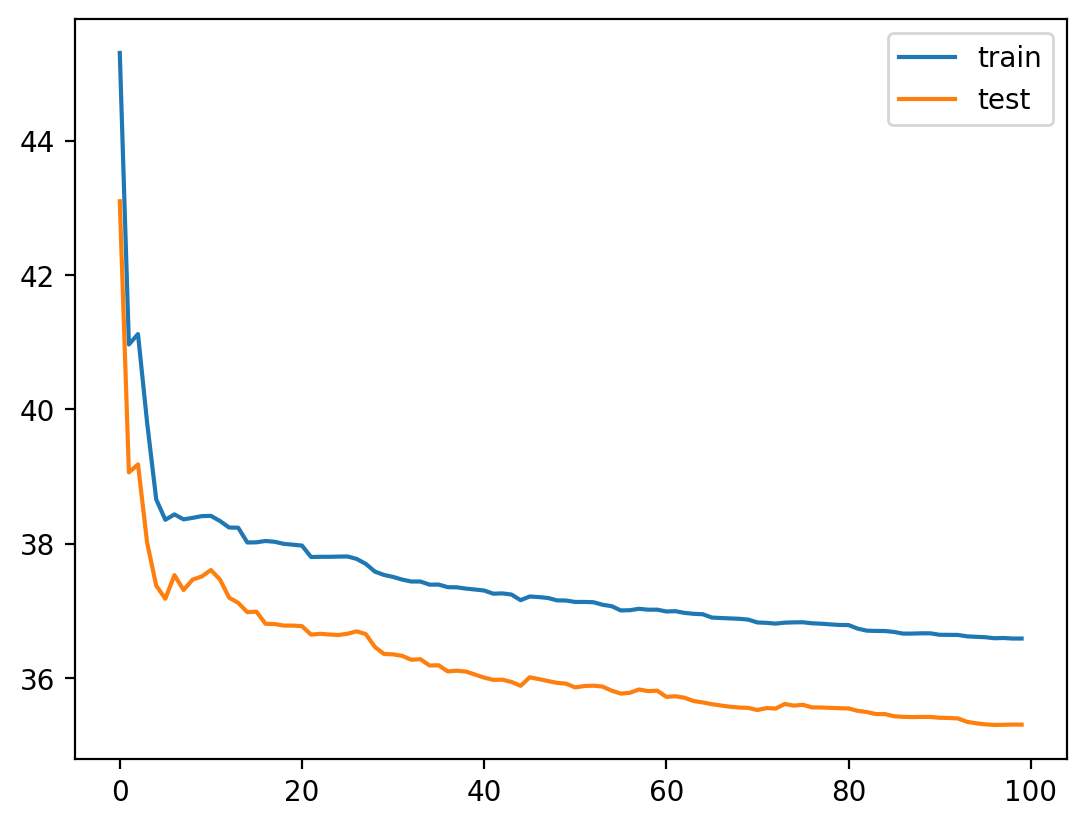

In [27]:
plt.plot(err_hist_train, label="train")
plt.plot(err_hist_test, label="test")
plt.legend()